# Example Notebook - Model Training + Example Trades

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

print(f"Current working directory: {os.getcwd()}")
print(f"Source code is in system path @ {sys.path[0]}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import optuna

Current working directory: /Users/joshgowdy/GitHub/GB-energy-trading/example_notebooks
Source code is in system path @ /Users/joshgowdy/GitHub/GB-energy-trading/code


/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from preprocessing import load_auction_data, load_forecasts,preprocess_data
from feature_engineering import make_new_price_indicators, generate_lag_timeseries, generate_close_timeseries
from train_classifier import timeseries_train_test_split, plot_model_validation

## Preprocessing

load and preprocess auction data

In [14]:
auction_data, _ = load_auction_data(['../data/raw/auction_data.csv', '../data/raw/system_prices.csv'])
auction_data = preprocess_data(auction_data)

# define spreads and spread directions binary labels
auction_data.loc[:,'auction_price_spread']=auction_data['price_second_auction']-auction_data['price_first_auction']
auction_data.loc[:,'system_price_spread']=auction_data['system_price']-auction_data['price_first_auction']
auction_data['auction_spread_dir']=(auction_data['auction_price_spread']>0).astype(int)
auction_data['system_spread_dir']=(auction_data['system_price_spread']>0).astype(int)

load and preprocess signals from forecasts of energy fundamentals

In [15]:
fundamentals =load_forecasts('../data/raw/forecast_features.csv')
fundamentals=preprocess_data(fundamentals)

make indicators

In [16]:
signals=auction_data.columns

# lag timeseries 24hr, 72hr, weekly
data=generate_lag_timeseries(auction_data, signals, 24)
data=generate_lag_timeseries(auction_data, signals, 72)
data=generate_lag_timeseries(auction_data, signals, 24*7)
# close timeseries i.e. the last available (closing) price from prevous day
data=generate_close_timeseries(auction_data, signals)

indicator_methods=[
                   ('ATR_24', 'calculate_ATR', {'window': 24, 'lag': 24}),
                   ('ATR_7', 'calculate_ATR', {'window': 24, 'lag': 7*24}),
                   ('MAD_24', 'calculate_MAD', {'window': 24}),
                   ('MAD_7', 'calculate_MAD', {'window': 7*24}),
                   ('RSTDEV_24', 'calculate_RSTDEV', {'window': 24}),
                   ('RSTDEV_7', 'calculate_RSTDEV', {'window': 7*24}),
                   ('ZSCORE_24', 'calculate_ZSCORE', {'window': 24}),
                   ('ZSCORE_7', 'calculate_ZSCORE', {'window': 7*24}),
                   ('ADX_24', 'calculate_ADX', {'window': 24}),
                   ('ADX_7', 'calculate_ADX', {'window': 7*24}),
                   ('PR_24', 'calculate_PR', {'window': 24}),
                   ('PR_7', 'calculate_PR', {'window': 7*24}),
                   ('RSI_24', 'calculate_RSI', {'window': 24}),
                   ('RSI_7', 'calculate_RSI', {'window': 7*24}),
                   ('MACD_24', 'calculate_MACD', {'window_smaller': 12, 'window_larger': 24}),
                   ('MACD_7', 'calculate_MACD', {'window_smaller': 7*12, 'window_larger': 7*24}),
                   ('MOM_1h', 'calculate_MOM', {'lag':1}),
                   ('MOM_3h', 'calculate_MOM', {'lag':3}),
                   ('MOM_6h', 'calculate_MOM', {'lag':6}),
                      
]           

timeseries=['auction_price_spread_lag24', 'system_price_spread_lag24', 'price_first_auction_lag24', 
            'price_second_auction_lag24',
       'traded_volume_first_auction_lag24', 'traded_volume_second_auction_lag24',
       'system_price_lag24']

data=make_new_price_indicators(auction_data, timeseries, indicator_methods)

Scale data and create validation folds

In [51]:
data=pd.concat([data, fundamentals], axis=1)

data=data.dropna(axis=0, how='any')
# the target is the auction spread direction i.e. positive or negative spread between the two day ahread auction prices
y=data[['auction_spread_dir']]

# drop all future (i.e. not lagged) columns from features
X=data.drop(columns=['auction_spread_dir',
                     'system_spread_dir', 
                     'price_second_auction', 
                     'system_price', 
                     'traded_volume_second_auction', 
                     'auction_price_spread',
                     'system_price_spread'])

# scale data with a standard scaler
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled = scaler.fit_transform(X_scaled)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_holdout = X_scaled.loc['2022-07-01':]
y_holdout = y.loc['2022-07-01':]

cv_folds=timeseries_train_test_split(X_scaled.loc[:'2022-07-01'], y.loc[:'2022-07-01'], 10)

Fold 0:
  Train: index=[   0    1    2 ... 1166 1167 1168]
  Test:  index=[1169 1170 1171 ... 2326 2327 2328]
Fold 1:
  Train: index=[   0    1    2 ... 2326 2327 2328]
  Test:  index=[2329 2330 2331 ... 3486 3487 3488]
Fold 2:
  Train: index=[   0    1    2 ... 3486 3487 3488]
  Test:  index=[3489 3490 3491 ... 4646 4647 4648]
Fold 3:
  Train: index=[   0    1    2 ... 4646 4647 4648]
  Test:  index=[4649 4650 4651 ... 5806 5807 5808]
Fold 4:
  Train: index=[   0    1    2 ... 5806 5807 5808]
  Test:  index=[5809 5810 5811 ... 6966 6967 6968]
Fold 5:
  Train: index=[   0    1    2 ... 6966 6967 6968]
  Test:  index=[6969 6970 6971 ... 8126 8127 8128]
Fold 6:
  Train: index=[   0    1    2 ... 8126 8127 8128]
  Test:  index=[8129 8130 8131 ... 9286 9287 9288]
Fold 7:
  Train: index=[   0    1    2 ... 9286 9287 9288]
  Test:  index=[ 9289  9290  9291 ... 10446 10447 10448]
Fold 8:
  Train: index=[    0     1     2 ... 10446 10447 10448]
  Test:  index=[10449 10450 10451 ... 11606 11607

## Forecaster Model Training

Logistic Regression

In [ ]:
model_config_LR={('penalty', 'l2'),
                 ('C', 1.0),
                 ('max_iter', 1000)}

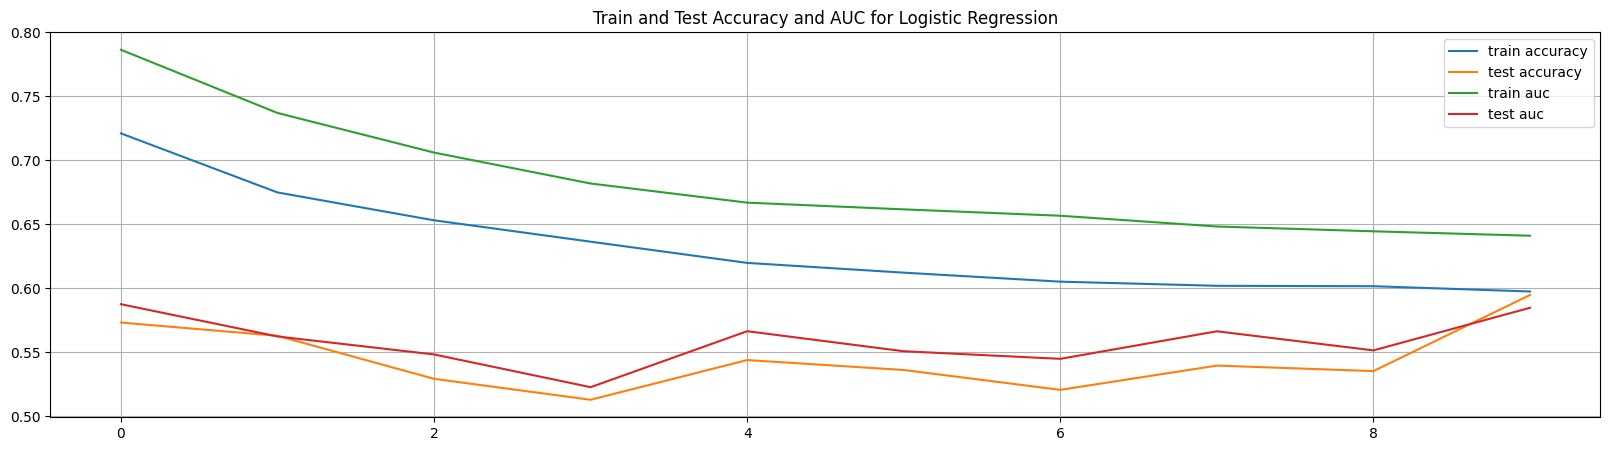

In [ ]:
log_reg = LogisticRegression(**model_config_LR)
plot_model_validation(cv_folds, log_reg)


The model is not overfitting. Training accuracy decreases as the training dataset is made larger (model is not memorising the larger datasets). But test accuracy only slightly increases, so the model is only slighty able to generalise better given more data.

For the final fold the model accuracies are the same on the test dataset and the train dataset.

The lack of improvement as more training data is added is likely due to the simplicity of the model. 

In [53]:
(X_train, y_train, X_test, y_test) = cv_folds[9]
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train['auction_spread_dir'])
y_pred_proba_LR = log_reg.predict_proba(X_test)[:, 1]